In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

/Users/Louis/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv('data/train.csv', sep=';')
df_test = pd.read_csv('data/test.csv', sep=';')
y_train = (df_train['VARIABLE_CIBLE'] == 'GRANTED').astype(int).ravel()
df_train.drop('VARIABLE_CIBLE', axis=1, inplace=True)

In [3]:
print("Patent granted proportion =",y_train.sum()/len(y_train))

Patent granted proportion = 0.584737367547


In [4]:
def imputer(df):
    features_num = list(df.columns[df.dtypes != 'object'])
    features_cat = list(df.columns[df.dtypes == 'object'])

    for i in features_cat:
        df.loc[df[i].isnull(), i] = "value_missing"
        
    df[features_cat] = df[features_cat].apply(LabelEncoder().fit_transform)
    df[features_num] = Imputer().fit_transform(df[features_num])
    
    return df

In [5]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right", fontsize=14)
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

In [6]:
X_train = imputer(df_train)

In [7]:
%%time
param_grid = {'logistic__C': np.logspace(-4,4,10)}
linear_pipe = Pipeline([('scaler', StandardScaler()),
                        ('logistic', LogisticRegression())])
linear_grid = GridSearchCV(linear_pipe, 
                           param_grid=param_grid,
                           scoring = 'roc_auc',
                           cv=5,
                           verbose=True)
linear_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.7min finished


CPU times: user 5min 45s, sys: 20.1 s, total: 6min 5s
Wall time: 5min 49s


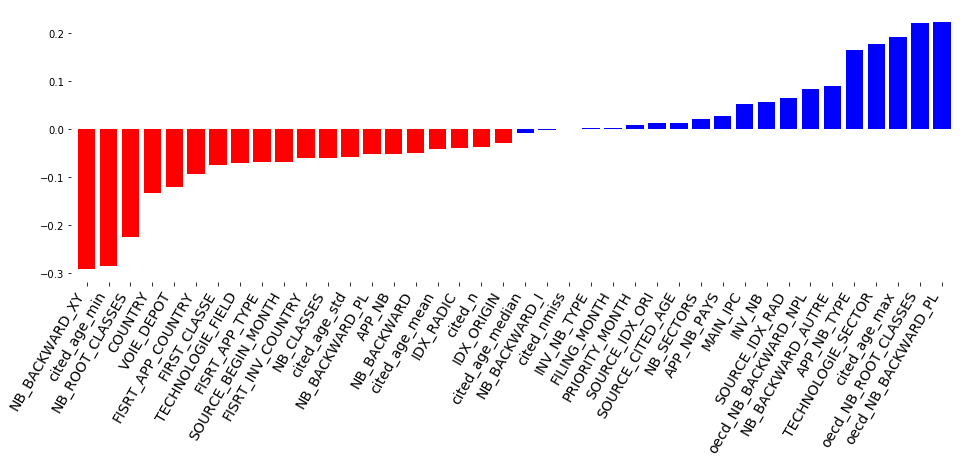

In [8]:
plt.figure(figsize=(16,5))
plot_important_features(linear_grid.best_estimator_.steps[1][1].coef_[0], X_train.columns, top_n=20)
plt.show()

In [9]:
OHE = OneHotEncoder(sparse=False)
OHE.fit(np.vstack((X_train,X_test)))
X_train = OHE.transform(X_train)
X_test = OHE.transform(X_test)

NameError: name 'X_test' is not defined

In [ ]:
for i in ['MAIN_IPC', 'FIRST_CLASSE']:
    lab = LabelEncoder()
    lab.fit(np.hstack((df[i].values,df_test[i].values)))
    X_train = np.c_[lab.transform(df[i].values),X_train]
    X_test = np.c_[lab.transform(df_test[i].values),X_test]

In [ ]:
X_train = np.c_[df[variables_num].values,X_train]
X_test = np.c_[df_test[variables_num].values,X_test]

begin_train = df['BEGIN_MONTH'].str.split('/', expand=True, n=1).astype(float)
begin_test = df_test['BEGIN_MONTH'].str.split('/', expand=True, n=1).astype(float)

In [ ]:
X_train = np.c_[(begin_train.values)[:,0]+((begin_train.values)[:,1])*12,X_train]
X_test = np.c_[(begin_test.values)[:,0]+((begin_test.values)[:,1])*12,X_test]

In [ ]:
dates = ['PRIORITY_MONTH', 'FILING_MONTH', 'PUBLICATION_MONTH']

for i in dates:
        temp_train=df[i].str.split('/', expand=True, n=1).astype(float)
        temp_test=df_test[i].str.split('/', expand=True, n=1).astype(float)
        X_train = np.c_[((temp_train.values)[:,0]+((temp_train.values)[:,1])*12)-((begin_train.values)[:,0]+((begin_train.values)[:,1])*12),X_train]
        X_test = np.c_[((temp_test.values)[:,0]+((temp_test.values)[:,1])*12)-((begin_test.values)[:,0]+((begin_test.values)[:,1])*12),X_test]

In [ ]:
clf = GradientBoostingClassifier(n_estimators=155,max_depth = 8, max_features=0.3)
score = cross_validation.cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
print('Score (optimiste) sur le train : %s' % score)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
np.savetxt('y_pred15.txt', y_pred[:,1], fmt='%s')